In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Problem 3

In [3]:
#Define constants
T=1
M=100
N=1000

#Define some different choices of a
def simple_a(x, t=0):
    return np.array((x-1/3)*(x-2/3))

def simple_a2(x, t=0):
    return np.array((x-1/4)*(x-3/4))

def simple_a3(x, t=0):
    return simple_a(x**2, t)

#a+ and a-
def pos_a(x, a):
    a_vec=a(x)
    null_vec=np.zeros(len(x))
    arr=np.maximum(null_vec, a_vec)
    return arr

def neg_a(x, a):
    null_vec=np.zeros(len(x))
    a_vec=-a(x)
    arr=np.maximum(null_vec, a_vec)
    return arr

#Matrix creator
def tridiag(lower, diag, upper):
    return np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)    

#Plot func
def plot_solutionTest(U1, U2=np.zeros((1,1)), U3=np.zeros((1,1)), angle=-30, filename="pdfName", name="Analytic function"):
    x_len = len(U1[:, ])
    t_len = len(U1[0])
    x=np.linspace(0, 1, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5), subplot_kw={"projection": "3d"})
    fig.suptitle(name, fontsize=14)
    tt, xx = np.meshgrid(t, x)
    ax[0].plot_surface(tt, xx, U1, cmap=cm.coolwarm)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[0].set_title(r'Numerical solution')
    ax[0].view_init(azim=angle)        # Rotate the figure
    if np.shape(U2)==np.shape(U1):
        ax[1].plot_surface(tt, xx, U2, cmap=cm.coolwarm)
        ax[1].set_xlabel('t')
        ax[1].set_ylabel('x')
        ax[1].set_zlabel('u')
        ax[1].set_title(r'Exact solution')
        ax[1].view_init(azim=angle)
    if np.shape(U3)==np.shape(U1):
        ax[2].plot_surface(tt, xx, U3, cmap=cm.coolwarm)
        ax[2].set_xlabel('t')
        ax[2].set_ylabel('x')
        ax[2].set_zlabel('u')
        ax[2].set_title(r'$u_{analytic} - u_{numerical}$')
        ax[2].view_init(azim=angle)              
    fig.savefig(filename)
    fig.tight_layout()
    

In [4]:
#Initial conditions for the solution with no RHS
def init_noRHS1(x):
    return np.exp(-x)*np.sin(2*np.pi*x)

def init_noRHS2(x):
    return np.cos(2*np.pi*x)

def init_noRHS3(x):
    return np.exp(-x**2)*np.sin(2*np.pi*(x-simple_a(x)))

#Boundary x=0
def bc_noRHS(t, init, a):
    return init(-a(0)*t) 

#t=0 without a RHS, u_0(x)
def exact_sol(f, x, a, t):
    tt, xx=np.meshgrid(t, x)
    return f(xx-a(xx, tt)*tt)

#Tests with RHS
#RHS
def withRHS1(t, x, a):
    tt, xx=np.meshgrid(t, x)
    return -2*tt*np.cos(2*np.pi*xx)*np.exp(-tt**2) - a(xx)*2*np.pi*np.sin(2*np.pi*xx)*np.exp(-tt**2)

#Exact function
def u_exact1(f, x, a, t):
    #tt, xx=np.meshgrid(t, x)
    return np.cos(2*np.pi*x)*np.exp(-t**2)

#Initial and boundary conditions
def init_RHS(x):
    return u_exact1(0, x, 0, 0)

def bc_RHS(t, init, a):
    return u_exact1(0, 0, 0, t)

def withRHS2(t, x, a):
    tt, xx=np.meshgrid(t, x)
    return -np.sin(2*np.pi*xx)*np.exp(-tt) + a(xx)*2*np.pi*np.cos(2*np.pi*xx)*np.exp(-tt)

def u_exact2(f, x, a, t):
    return np.sin(2*np.pi*x)*np.exp(-t)

def init_RHS2(x):
    return u_exact2(0, x, 0, 0)

def bc_RHS2(t, init, a):
    return u_exact2(0, 0, 0, t)

def withRHS3(t, x, a):
    tt, xx=np.meshgrid(t, x)
    return 2*np.pi*np.cos(2*np.pi*xx)*np.cos(2*np.pi*tt) - a(xx)*2*np.pi*np.sin(2*np.pi*xx)*np.sin(2*np.pi*tt)

def u_exact3(f, x, a, t):
    return np.cos(2*np.pi*x)*np.sin(2*np.pi*t)

def init_RHS3(x):
    return u_exact3(0, x, 0, 0)

def bc_RHS3(t, init, a):
    return u_exact3(0, 0, 0, t)

In [5]:
#Create the scheme
def upwind(M, T, N, u_init, u_bc, a=simple_a, RHS_func=lambda t, x, a:np.zeros((len(x), len(t)))):
    
    h=1/M
    k=T/N
    
    t=np.linspace(0, T, N+1)
    x=np.linspace(0, 1, M+1)
    
    U=np.zeros((M+1, N+1))

    U[:, 0]=u_init(x)
    
    lower=(k/h)*pos_a(x, a)[1:]
    middle=np.ones(len(x))-(k/h)*pos_a(x, a)[:]-(k/h)*neg_a(x, a)[:]
    upper=(k/h)*neg_a(x, a)[:-1]
    
    A=tridiag(lower, middle, upper)

    CFL=k/h*a(x)    
    
    F=RHS_func(t, x, a)
    
    for n in range(N):

        U[:, n+1]=A@U[:, n] + k*F[:, n]
        U[0, n+1]=u_bc(t[n+1], u_init, a) 
    

    return U, CFL

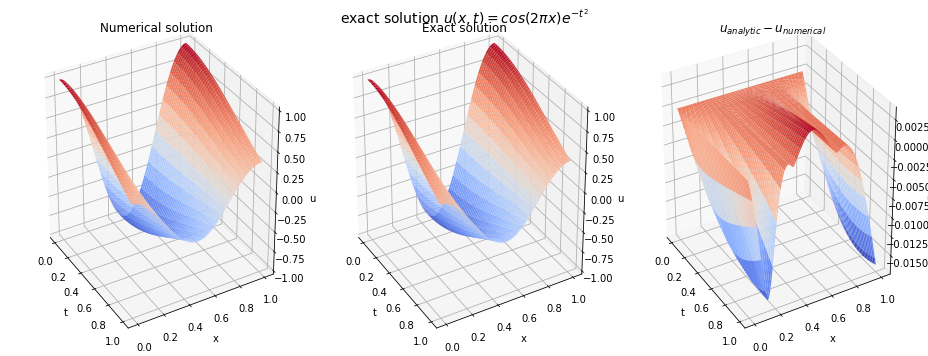

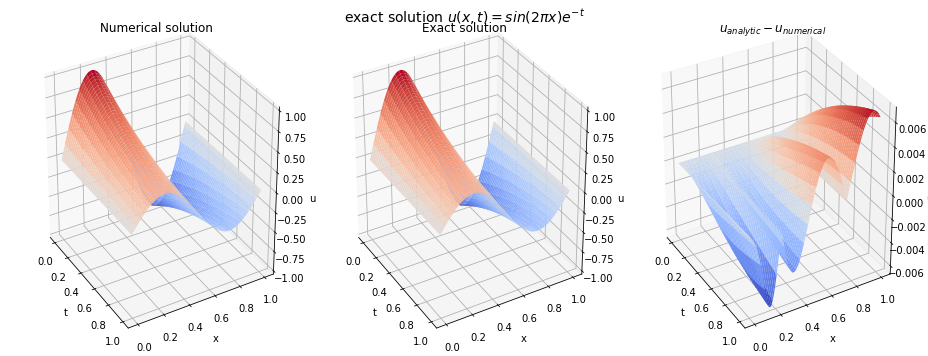

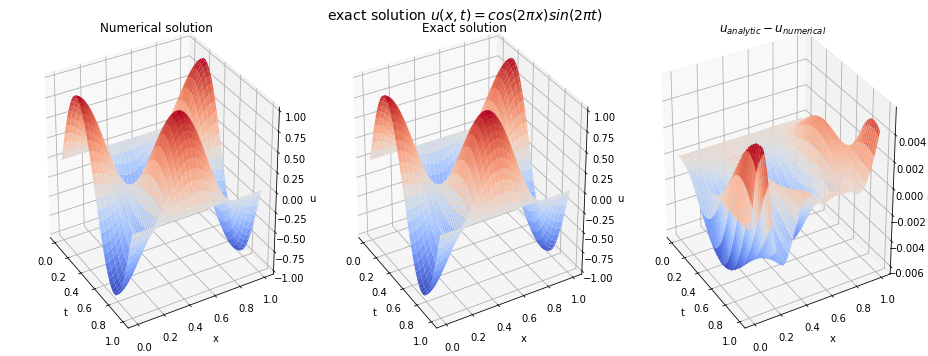

In [7]:
#For simplicity
x_testing=np.linspace(0, 1, M+1)
t_testing=np.linspace(0, T, N+1)


#Numerical solution without right hand side
noRHS1, noRHSCFL1=upwind(M, T, N, init_noRHS1, bc_noRHS)

#Exact solution
exact1=exact_sol(init_noRHS1, xxx, simple_a, ttt)

#Error
diff1=noRHS1-exact1

#Test with right hand sides
RHS1, RHS1CFL=upwind(M, T, N, init_RHS, bc_RHS, a=simple_a, RHS_func=withRHS1)

t_global, x_global=np.meshgrid(t_testing, x_testing)
exactRHS1=u_exact1(0, x_global, simple_a, t_global)

diffRHS=RHS1 - exactRHS1


RHS2, RHS2CFL=upwind(M, T, N, init_RHS2, bc_RHS2, a=simple_a2, RHS_func=withRHS2)

exactRHS2=u_exact2(0, x_global, simple_a2, t_global)

diffRHS2=RHS2 - exactRHS2


RHS3, RHS3CFL=upwind(M, T, N, init_RHS3, bc_RHS3, a=simple_a3, RHS_func=withRHS3)


exactRHS3=u_exact3(0, x_global, simple_a3, t_global)

diffRHS3=RHS3 - exactRHS3

plot_solutionTest(RHS1, exactRHS1, diffRHS, angle=-30, filename="numeric upwind vs exact test 1", name=r'exact solution $u(x,t)=cos(2\pi x)e^{-t^2}$')
plot_solutionTest(RHS2, exactRHS2, diffRHS2, angle=-30, filename="numeric upwind vs exact test 2", name=r'exact solution $u(x,t)=sin(2\pi x)e^{-t}$ ')
plot_solutionTest(RHS3, exactRHS3, diffRHS3, angle=-30, filename="numeric upwind vs exact test 3", name=r'exact solution $u(x,t)=cos(2\pi x)sin(2\pi t)$')

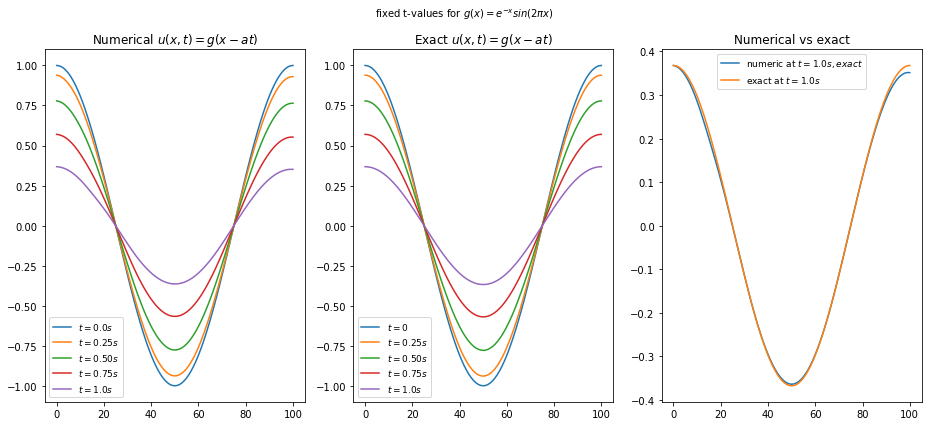

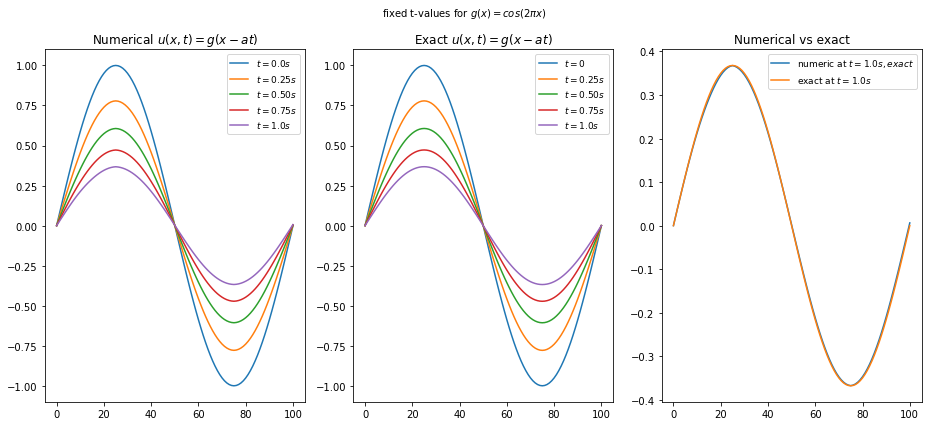

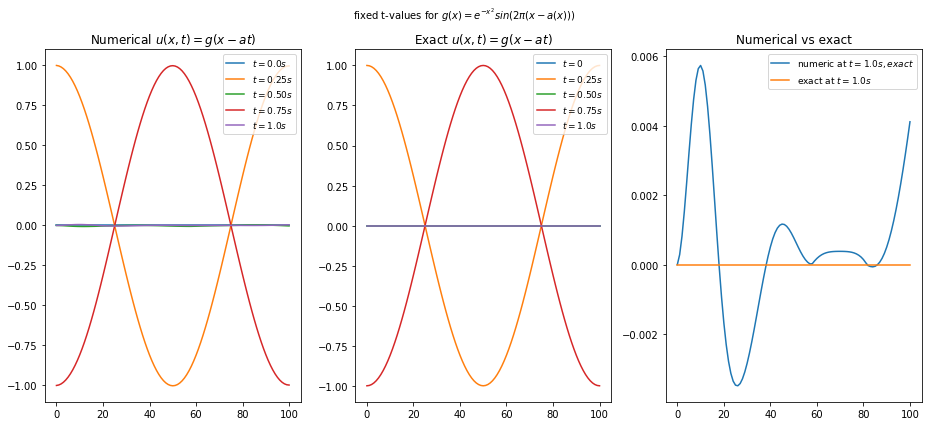

In [8]:
#To get perspective
def plot_func2(numeric, exact, title="Title", savefig="fixed t-values1"):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6))
    fig.suptitle(title, fontsize=10)
    
    ax1.plot(numeric[:, 0], label=r'$t=0.0s$')
    ax2.plot(exact[:, 0], label=r'$t=0$')

    ax1.plot(numeric[:, int(N*1/4)], label=r'$t=0.25s$')
    ax2.plot(exact[:, int(N*1/4)], label=r'$t=0.25s$')

    ax1.plot(numeric[:, int(N*1/2)], label=r'$t=0.50s$')
    ax2.plot(exact[:, int(N*1/2)], label=r'$t=0.50s$')

    ax1.plot(numeric[:, int(N*3/4)], label=r'$t=0.75s$')
    ax2.plot(exact[:, int(N*3/4)], label=r'$t=0.75s$')
    
    ax1.plot(numeric[:, -1], label=r'$t=1.0s$')
    ax2.plot(exact[:, -1], label=r'$t=1.0s$')
    ax3.plot(numeric[:, -1], label=r'numeric at $t=1.0s, exact$')
    ax3.plot(exact[:, -1], label=r'exact at $t=1.0s$')
    
    ax1.set_title(r'Numerical $u(x, t)=g(x-at)$')
    ax2.set_title(r'Exact $u(x, t)=g(x-at)$')
    ax3.set_title(r'Numerical vs exact')
    ax1.legend(prop={'size': 9})
    ax2.legend(prop={'size': 9})
    ax3.legend(prop={'size': 9})
    fig.savefig(savefig)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
plot_func2(RHS1, exactRHS1, title=r'fixed t-values for $g(x)=e^{-x}sin(2\pi x)$', savefig="fixed t-values1") 
plot_func2(RHS2, exactRHS2, title=r'fixed t-values for $g(x)=cos(2\pi x)$', savefig="fixed t-values2")
plot_func2(RHS3, exactRHS3, title=r'fixed t-values for $g(x)=e^{-x^2}sin(2\pi\left(x-a(x))\right)$', savefig="fixed t-values3")

In [17]:
#Define an error function for a given method in space
def error_func_h(solver, init, bc, a=simple_a, exact_func=exact_sol, RHS_func= lambda t, x: np.zeros((len(x), len(t)))):
    N=1000
    Ms=np.arange(3, 100,5)
    hs=1/Ms
    t=np.linspace(0, T, N+1)
    error= np.zeros(len(hs))
    for i in range(len(Ms)):
        u_numeric, temp = solver(Ms[i], T, N, init, bc, a, RHS_func)
        x=np.linspace(0, 1, Ms[i]+1)
        tt, xx=np.meshgrid(t, x)
        u_exact_ref = exact_func(init, xx, a, tt)
        error[i] = np.max( np.abs(u_numeric[-1, :] - u_exact_ref[-1, :] ))
    order = np.polyfit(np.log(hs),np.log(error),1)[0]
    return hs, error , order

h_RHS1, error_RHS1, order_RHS1 = error_func_h(upwind, init_RHS, bc_RHS, a=simple_a, exact_func=u_exact1, RHS_func=withRHS1)
h_RHS2, error_RHS2, order_RHS2 = error_func_h(upwind, init_RHS2, bc_RHS2, a=simple_a, exact_func=u_exact2, RHS_func=withRHS2)
h_RHS3, error_RHS3, order_RHS3 = error_func_h(upwind, init_RHS3, bc_RHS3, a=simple_a, exact_func=u_exact3, RHS_func=withRHS3)

0.977202061604788 1.0316564390217666 1.1601943088266544


In [19]:
Uref_k_RHS1, temp4 = upwind(20, T, 10000, init_RHS, bc_RHS, a=simple_a, RHS_func=withRHS1)
Uref_k_RHS2, temp5 = upwind(20, T, 10000, init_RHS2, bc_RHS2, a=simple_a, RHS_func=withRHS2)
Uref_k_RHS3, temp6 = upwind(20, T, 10000, init_RHS3, bc_RHS3, a=simple_a, RHS_func=withRHS3)

#Error function in time
def error_func_k(solver, init, bc, u_ref, a=simple_a, RHS_def= lambda t, x, a: np.zeros((len(x), len(t)))):
    Ms=20
    Ns=np.arange(3, 2000, 100)
    ks=1/Ns
    error=np.zeros(len(ks))
    for i in range(len(Ns)):
        u_numeric, temp = solver(Ms, T, Ns[i], init, bc, a=simple_a, RHS_func=RHS_def)
        error[i] = np.max(np.abs(u_numeric[:, -1] - u_ref[:, -1]))
    order=np.polyfit(np.log(ks), np.log(error), 1)[0]
    return ks, error, order

ks_RHS1, error_k_RHS1, order_k_RHS1= error_func_k(upwind, init_RHS, bc_RHS, Uref_k_RHS1, a=simple_a, RHS_def=withRHS1)
ks_RHS2, error_k_RHS2, order_k_RHS2= error_func_k(upwind, init_RHS2, bc_RHS2, Uref_k_RHS2, a=simple_a, RHS_def=withRHS2)
ks_RHS3, error_k_RHS3, order_k_RHS3= error_func_k(upwind, init_RHS3, bc_RHS3, Uref_k_RHS3, a=simple_a, RHS_def=withRHS3)



1.0613650978754248 1.042053537709822 1.1416773277838554


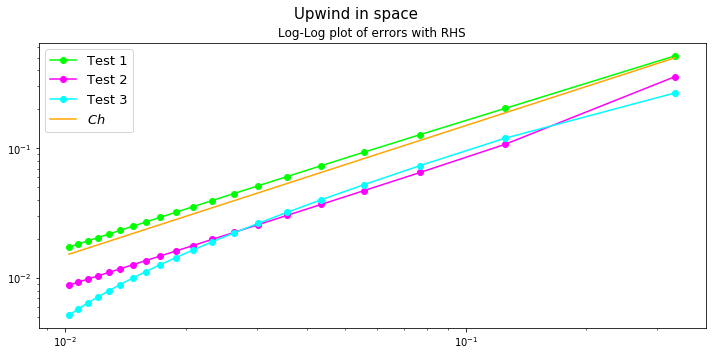

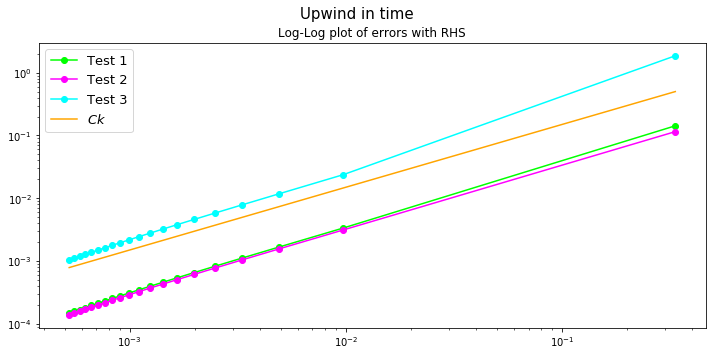

In [20]:
#log-log plots
def convergence_plot(arr1, arr2, arr3, ref, c=1.5, scheme="Scheme", time_or_space=r'$C$'):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle(scheme, fontsize=15)
    
    ax1.loglog(ref, arr1, 'o-', linestyle='-', color="lime", label="Test 1")
    ax1.loglog(ref, arr2, 'o-', linestyle='-', color="magenta", label="Test 2")
    ax1.loglog(ref, arr3, 'o-', linestyle='-', color="cyan", label="Test 3")
    ax1.loglog(ref, c*ref, color="orange", label=time_or_space)
    ax1.legend()
    ax1.legend(prop={'size': 13})
    ax1.set_title(r'Log-Log plot of errors with RHS')
    fig.savefig("Error plots Upwind")
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

convergence_plot(error_RHS1, error_RHS2, error_RHS3, h_RHS1, c=1.5, scheme="Upwind in space", time_or_space=r'$C h$') 
convergence_plot(error_k_RHS1, error_k_RHS2, error_k_RHS3, ks_RHS1, c=1.5, scheme="Upwind in time", time_or_space=r'$C k$')